In [1]:
import pandas as pd
import pickle

from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import tree

import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np

In [2]:
pd.set_option('display.max_columns',None)

In [3]:
players = pd.read_csv("../processed_data/clean/players.csv",index_col = 0)
players.head()

,height,weight,birthDate,collegeName,position,displayName
nflId,,,,,,
2539334,1.83,86,1990-09-10,Washington,CB,Desmond Trufant
2539653,1.78,84,1988-11-01,Southeastern Louisiana,CB,Robert Alford
2543850,1.75,84,1991-12-18,Purdue,SS,Ricardo Allen
2555162,1.85,103,1994-11-04,Louisiana State,MLB,Deion Jones
2555255,1.91,105,1993-07-01,Minnesota,OLB,De'Vondre Campbell


In [4]:
summary = pd.read_csv("summary_teams.csv",index_col=2)
summary

,Unnamed: 0,playId,areaDifference,numberPlayersDeep,numberPlayersDeepDifference,numberPlayersUnderneath,densityDifference,heightDifference,widthDifference,cluster,homeScore,visitorScore,down,quarter,yardsToGo,yardsToEndZone,gameClock,defenseValoration
defenseTeam,,,,,,,,,,,,,,,,,,
PHI,0,2018090600:190:1,55.82550,1,1,5,0.107478,2.76,-10.15,0.0,0.0,0.0,3,1,10,39.0,13:01:00,0
ATL,2,2018090600:344:1,7.82150,1,1,6,0.894969,-0.36,-12.15,0.0,0.0,0.0,3,1,4,102.0,09:24:00,1
PHI,4,2018090600:949:1,64.43250,1,1,6,0.108641,1.64,-6.25,0.0,0.0,3.0,3,2,12,92.0,15:00:00,1
ATL,5,2018090600:1037:1,164.09500,2,1,4,0.036564,5.41,-9.52,1.0,0.0,3.0,3,2,7,57.0,12:53:00,0
ATL,8,2018090600:1801:1,126.91500,1,0,6,0.055155,2.64,-12.52,0.0,3.0,6.0,3,2,3,64.0,01:35:00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SEA,4550,2018123015:2373:17,-51.20585,1,1,5,-0.117174,2.10,-11.24,0.0,14.0,13.0,3,3,2,83.0,11:58:00,1
SEA,4551,2018123015:2629:17,244.93410,2,2,5,0.028579,8.79,-2.86,0.0,14.0,13.0,3,3,13,58.0,07:43:00,1
SEA,4552,2018123015:2998:17,-72.03590,1,1,5,-0.083292,5.48,-8.06,0.0,21.0,13.0,3,3,10,80.0,04:17:00,1


In [5]:
summary.drop(["Unnamed: 0"],axis=1,inplace=True)

In [6]:
len(summary[summary["defenseValoration"]==0])/len(summary)

0.39392352016762705

In [7]:
len(summary[summary["defenseValoration"]==1])/len(summary)

0.606076479832373

# Cambiar valor gameClock

In [8]:
from datetime import datetime
s1 = "15:00:00"
s2 = "03:29:00"
format = "%M:%S:%f"
time = datetime.strptime(s1, format) - datetime.strptime(s2, format)
print(time.total_seconds())
print(str(time).split(":"))

691.0
['0', '11', '31']


In [9]:
def changeGameClock(value,quarter):
    if quarter == 1:
        total_time = 3600
    elif quarter == 2:
        total_time = 2700
    elif quarter == 3:
        total_time = 1800
    elif quarter == 4:
        total_time = 900
    elif quarter == 5:
        total_time = 900
    
    format = "%M:%S:%f"
    actual_time = datetime.strptime(value, format) - datetime.strptime("00:00:00",format)
    time = total_time - (900 - actual_time.total_seconds())
    return time

In [10]:
changeGameClock("00:07:00",2)

1807.0

In [11]:
summary_cp = summary.copy()

In [12]:
summary_cp["gameClock"] = summary_cp.apply(lambda x: changeGameClock(x["gameClock"],x["quarter"]),axis=1)

In [13]:
summary_cp.drop(["playId"],axis=1,inplace=True)

In [14]:
summary_cp

,areaDifference,numberPlayersDeep,numberPlayersDeepDifference,numberPlayersUnderneath,densityDifference,heightDifference,widthDifference,cluster,homeScore,visitorScore,down,quarter,yardsToGo,yardsToEndZone,gameClock,defenseValoration
defenseTeam,,,,,,,,,,,,,,,,
PHI,55.82550,1,1,5,0.107478,2.76,-10.15,0.0,0.0,0.0,3,1,10,39.0,3481.0,0
ATL,7.82150,1,1,6,0.894969,-0.36,-12.15,0.0,0.0,0.0,3,1,4,102.0,3264.0,1
PHI,64.43250,1,1,6,0.108641,1.64,-6.25,0.0,0.0,3.0,3,2,12,92.0,2700.0,1
ATL,164.09500,2,1,4,0.036564,5.41,-9.52,1.0,0.0,3.0,3,2,7,57.0,2573.0,0
ATL,126.91500,1,0,6,0.055155,2.64,-12.52,0.0,3.0,6.0,3,2,3,64.0,1895.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SEA,-51.20585,1,1,5,-0.117174,2.10,-11.24,0.0,14.0,13.0,3,3,2,83.0,1618.0,1
SEA,244.93410,2,2,5,0.028579,8.79,-2.86,0.0,14.0,13.0,3,3,13,58.0,1363.0,1
SEA,-72.03590,1,1,5,-0.083292,5.48,-8.06,0.0,21.0,13.0,3,3,10,80.0,1157.0,1


In [15]:
X_train, X_test, y_train, y_test = train_test_split(summary_cp.drop(["defenseValoration"],axis=1),summary_cp["defenseValoration"],test_size=0.3)

In [25]:
from sklearn.model_selection import GridSearchCV
tree_param = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,16,17,18,19,20,21,22,23,24,25],'min_samples_split':[2,4,6,8,10,12,14,16,18,20,22,24,26,28,30],
             'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30],'splitter':["best","random"],
              'class_weight':[{0:6,1:4},{0:1,1:1},{0:2,1:1},{0:3,1:1},{0:4,1:2}]}
tree_model = tree.DecisionTreeClassifier()
clf = GridSearchCV(tree_model, tree_param)

In [ ]:
clf.fit(X_train,y_train)

In [ ]:
clf.best_params_

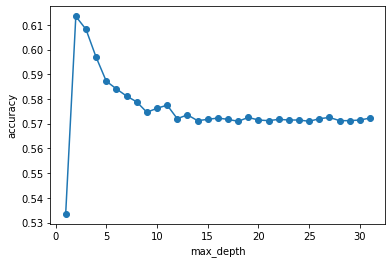

In [16]:
from sklearn import tree
from sklearn.model_selection import KFold

cv = KFold(n_splits = 10, shuffle = False) # 
accuracies = list()
max_attributes = len(list(summary_cp))
depth_range = range(1, max_attributes * 2)

# from 1 to number of features * 2

for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='entropy', 
                                             min_samples_split = 65, 
                                             min_samples_leaf = 20,
                                             max_depth = depth,
                                             class_weight={0:6,1:4}
                                            )
    for train_fold, test_fold in cv.split(summary_cp):
        f_train = summary_cp.iloc[train_fold]
        f_test = summary_cp.iloc[test_fold]
        
        model = tree_model.fit( X = f_train.drop(['defenseValoration'], axis=1), 
                               y = f_train['defenseValoration'])
        test_acc = model.score(X = f_test.drop(['defenseValoration'], axis=1), 
                                y = f_test['defenseValoration'])
        fold_accuracy.append(test_acc)
        
    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    
import matplotlib.pyplot as plt    
plt.plot(depth_range, accuracies, marker='o')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.show()

In [17]:
from sklearn.metrics import accuracy_score
regressor = tree.DecisionTreeClassifier(criterion='entropy', max_depth = 11,min_samples_leaf=1,min_samples_split=2,splitter="random",class_weight={0:6,1:4})
regressor.fit( X = X_train, y = y_train)
y_pred = regressor.predict(X = X_test)
acc = accuracy_score(y_test, y_pred)
print ('Acc', acc)

Acc 0.5575916230366492


In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,normalize=False,title=None,cmap=plt.cm.Blues):
  
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix
[[0.58486239 0.41513761]
 [0.45915493 0.54084507]]


TypeError: 'str' object is not callable

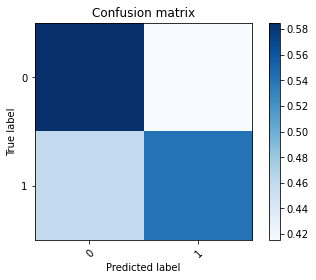

In [19]:
plot_confusion_matrix(y_test, y_pred, classes=unique_labels(y_test,y_pred), normalize=True,
                      title='Confusion matrix')

In [20]:
predict_proba = regressor.predict_proba(summary_cp.drop(["defenseValoration"],axis=1))[:,1]

In [21]:
summary["predict_proba"] = predict_proba - (1 - predict_proba)
summary

,playId,areaDifference,numberPlayersDeep,numberPlayersDeepDifference,numberPlayersUnderneath,densityDifference,heightDifference,widthDifference,cluster,homeScore,visitorScore,down,quarter,yardsToGo,yardsToEndZone,gameClock,defenseValoration,predict_proba
defenseTeam,,,,,,,,,,,,,,,,,,
PHI,2018090600:190:1,55.82550,1,1,5,0.107478,2.76,-10.15,0.0,0.0,0.0,3,1,10,39.0,13:01:00,0,0.466667
ATL,2018090600:344:1,7.82150,1,1,6,0.894969,-0.36,-12.15,0.0,0.0,0.0,3,1,4,102.0,09:24:00,1,0.837838
PHI,2018090600:949:1,64.43250,1,1,6,0.108641,1.64,-6.25,0.0,0.0,3.0,3,2,12,92.0,15:00:00,1,0.307692
ATL,2018090600:1037:1,164.09500,2,1,4,0.036564,5.41,-9.52,1.0,0.0,3.0,3,2,7,57.0,12:53:00,0,-0.105263
ATL,2018090600:1801:1,126.91500,1,0,6,0.055155,2.64,-12.52,0.0,3.0,6.0,3,2,3,64.0,01:35:00,1,-0.173913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SEA,2018123015:2373:17,-51.20585,1,1,5,-0.117174,2.10,-11.24,0.0,14.0,13.0,3,3,2,83.0,11:58:00,1,-0.173913
SEA,2018123015:2629:17,244.93410,2,2,5,0.028579,8.79,-2.86,0.0,14.0,13.0,3,3,13,58.0,07:43:00,1,0.281853
SEA,2018123015:2998:17,-72.03590,1,1,5,-0.083292,5.48,-8.06,0.0,21.0,13.0,3,3,10,80.0,04:17:00,1,0.281853


In [22]:
predict_proba_sums = summary.groupby(summary.index)["predict_proba"].sum()
predict_proba_sums

defenseTeam
ARI    10.812497
ATL     8.795638
BAL     7.913786
BUF     7.700746
CAR    10.989317
CHI     4.460613
CIN     5.352492
CLE     8.197228
DAL    -1.180354
DEN     1.059985
DET     1.780466
GB     -0.276302
HOU     5.362746
IND     1.752375
JAX    13.552219
KC     11.001759
LA      8.512115
LAC    13.911252
MIA    -2.024192
MIN    19.985908
NE     13.215339
NO      3.278617
NYG    11.049146
NYJ    15.059670
OAK     0.455680
PHI     3.634435
PIT    18.085146
SEA     0.450583
SF     10.853788
TB     16.731933
TEN    17.150970
WAS     1.611326
Name: predict_proba, dtype: float64

In [24]:
predict_proba_sums.sort_values(ascending=False)

defenseTeam
MIN    19.985908
PIT    18.085146
TEN    17.150970
TB     16.731933
NYJ    15.059670
LAC    13.911252
JAX    13.552219
NE     13.215339
NYG    11.049146
KC     11.001759
CAR    10.989317
SF     10.853788
ARI    10.812497
ATL     8.795638
LA      8.512115
CLE     8.197228
BAL     7.913786
BUF     7.700746
HOU     5.362746
CIN     5.352492
CHI     4.460613
PHI     3.634435
NO      3.278617
DET     1.780466
IND     1.752375
WAS     1.611326
DEN     1.059985
OAK     0.455680
SEA     0.450583
GB     -0.276302
DAL    -1.180354
MIA    -2.024192
Name: predict_proba, dtype: float64